# WTG Wind Farm

Power curve:

| Wind Speed (m/s) | Power Output (W) | Coefficient of Thrust (Ct) |
|------------------|------------------|----------------------------|
- your own wind tubrine power curve data is needed here

Grid curtailment: 91mW

-> We will be limiting power output per turbine to 6066 kW


In [3]:
from py_wake.wind_turbines import WindTurbines
from py_wake.wind_turbines.power_ct_functions import PowerCtTabular

In [4]:
wind_speeds = #DEFINE_YOUR_OWN
power_output = #DEFINE_YOUR_OWN
ct = #DEFINE_YOUR_OWN

In [5]:
rated_power = 91 # mW
rated_power_per_turbine = int(rated_power * 1000 / 15) # kW
print(rated_power_per_turbine)

6066


**Turbine data:**
- hub height: 122.5 m
- rotor diameter: 155 m

In [6]:
power_output = [min(p, rated_power_per_turbine) for p in power_output]
power_ct_function = PowerCtTabular(ws=wind_speeds, power=power_output, power_unit='kW', ct=ct)

turbines = WindTurbines(names=['WTG'],
                        diameters=[155],
                        hub_heights=[122.5],
                        powerCtFunctions=[power_ct_function])

**Site data:**
- from the provided kml file we are going to exact center latitude and longitude and use this information to access Global Wind Atlas API for wind data in that area
- rougness - I used 0.1, which is usual for cropland
- ti - turbulence intensity; I set it to 0.6 but seems like changing this does not affect the final result
- height - 120 m

In [7]:
import xml.etree.ElementTree as ET

def parse_kml_coordinates(kml_file):
    tree = ET.parse(kml_path)
    root = tree.getroot()

    ns = {'kml': 'http://www.opengis.net/kml/2.2'}

    coordinates_list = []

    for placemark in root.findall('.//kml:Placemark', ns):
        point = placemark.find('.//kml:Point/kml:coordinates', ns)
        if point is not None:
            coords = point.text.strip().split(',')
            lon = float(coords[0])
            lat = float(coords[1])
            coordinates_list.append((lat, lon))

    return coordinates_list

def calculate_centroid(coordinates):
    # Calculate the average of latitudes and longitudes
    sum_lat = sum(lat for lat, lon in coordinates)
    sum_lon = sum(lon for lat, lon in coordinates)
    centroid_lat = sum_lat / len(coordinates)
    centroid_lon = sum_lon / len(coordinates)
    return centroid_lat, centroid_lon

# Usage
kml_path = #PATH_TO_KML_FILE_WHERE_TURBINE_LOCATION_DATA_IS_SAVED
coordinates = parse_kml_coordinates(kml_path)
centroid = calculate_centroid(coordinates)
print(f"Centroid Latitude: {centroid[0]}, Centroid Longitude: {centroid[1]}")

Centroid Latitude: 43.95986876068875, Centroid Longitude: 15.690809957736798


In [8]:
lat = centroid[0]
long = centroid[1]
height = 120 
roughness = 0.1
ti = 0.6

from py_wake.site.xrsite import GlobalWindAtlasSite
gwa_site = GlobalWindAtlasSite(lat, long, height, roughness, ti=ti)

In [9]:
ds = gwa_site.ds

Let's examine wind data distribution from the extracted site.

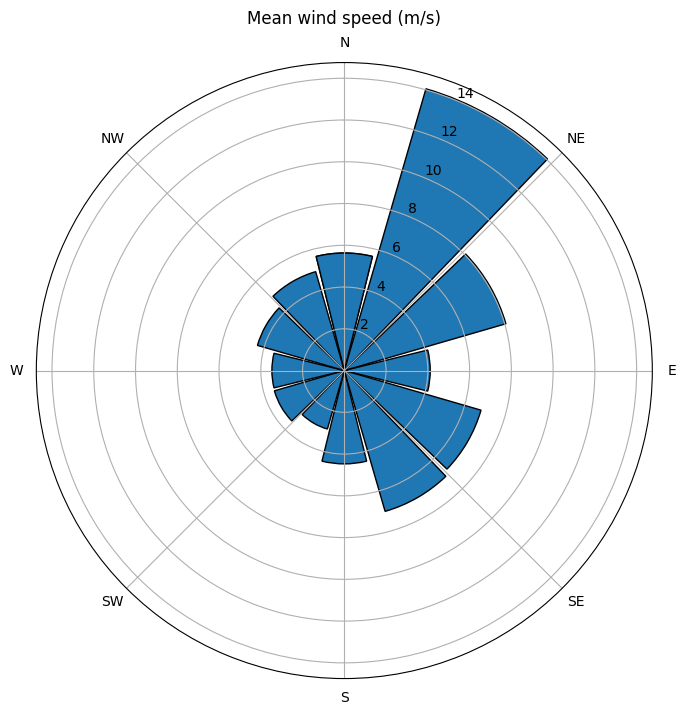

In [10]:
import matplotlib.pyplot as plt
import numpy as np

from scipy.special import gamma

mean_wind_speeds = ds['Weibull_A'] * gamma(1 + 1 / ds['Weibull_k'])

mean_wind_speeds = mean_wind_speeds.to_dataframe(name='Mean Wind Speed')
mean_wind_speeds.reset_index(inplace=True)
mean_wind_speeds

plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

# Convert wind direction from degrees to radians for plotting
direction_radians = np.radians(mean_wind_speeds['wd'])

# Plot the wind rose
bars = ax.bar(direction_radians, mean_wind_speeds['Mean Wind Speed'], width=np.radians(360 / len(mean_wind_speeds['wd'])), bottom=0.0, edgecolor='black')

# Set the direction of North to the top and set clockwise direction
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)

# Set the labels for the cardinal directions
ax.set_xticks(np.radians([0, 45, 90, 135, 180, 225, 270, 315]))
ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])

# Add title and set the limit for radial axis
ax.set_title('Mean wind speed (m/s)', va='bottom')

plt.show()

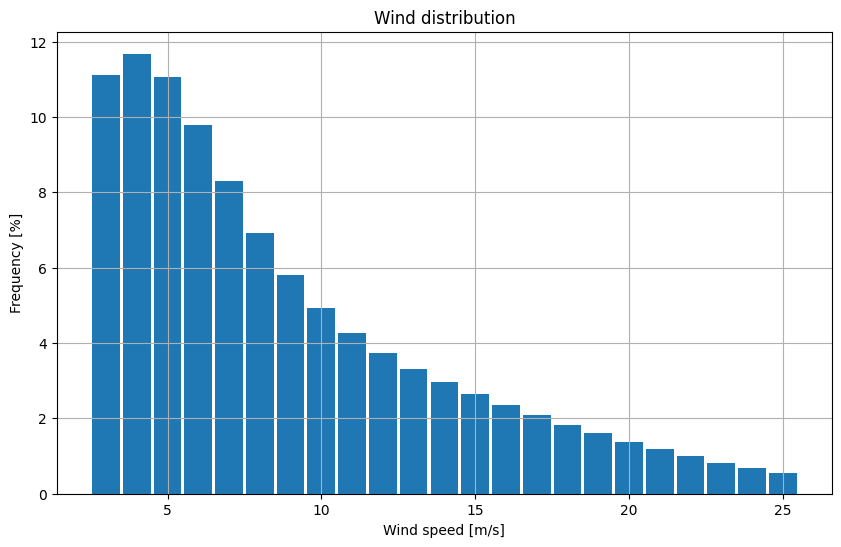

In [11]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate Weibull Probability Density Function
def weibull_pdf(ws, A, k):
    """Calculate Weibull PDF for given wind speed ws, scale parameter A, and shape parameter k."""
    return (k / A) * (ws / A)**(k - 1) * np.exp(-(ws / A)**k)

pdf_total = np.zeros_like(ds['ws'].values, dtype=float)

for wd in ds['wd'].values:
    A = ds['Weibull_A'].sel(wd=wd).values
    k = ds['Weibull_k'].sel(wd=wd).values
    freq = ds['Sector_frequency'].sel(wd=wd).values
    for i, ws in enumerate(ds['ws'].values):
        pdf = weibull_pdf(ws, A, k)
        pdf_total[i] += pdf * freq

pdf_total /= pdf_total.sum()
pdf_total *= 100


ws_values = ds['ws'].values
bar_width = np.diff(ws_values).mean()  
gap_percentage = 0.1 
adjusted_bar_width = bar_width * (1 - gap_percentage)

# Plotting the wind distribution histogram
plt.figure(figsize=(10, 6))
plt.bar(ws_values, pdf_total, width=adjusted_bar_width, align='center')
plt.xlabel('Wind speed [m/s]')
plt.ylabel('Frequency [%]')
plt.title('Wind distribution')
plt.grid(True)
plt.show()


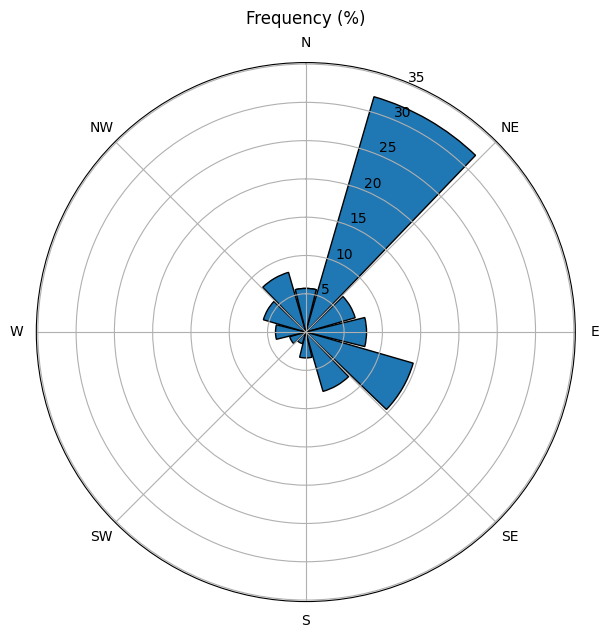

In [12]:
plt.figure(figsize=(7, 7))
ax = plt.subplot(111, polar=True)

# Sector frequencies are assumed to represent the frequency of occurrence of wind from each direction
sector_frequencies = ds['Sector_frequency'].values
sector_frequencies *= 100
directions = np.radians(ds['wd'].values)

# Wind Rose for Frequency
bars = ax.bar(directions, sector_frequencies, width=np.radians(360 / len(ds['wd'])), bottom=0.0, edgecolor='black')

# Set the direction of North to the top and set clockwise direction
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)

# Set the labels for the cardinal directions
ax.set_xticks(np.radians([0, 45, 90, 135, 180, 225, 270, 315]))
ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])

# Add title and set the limit for radial axis
ax.set_title('Frequency (%)', va='bottom')
ax.set_ylim(0, max(sector_frequencies) + (max(sector_frequencies) * 0.1))  # Extend the radial limit to add some space

plt.show()


In [13]:
from py_wake import NOJ
"""
Wake
Wake Model: N.O. Jensen (RISØ/EMD) Park 2 2018
Wake decay constant: 0.090 DTU default onshore Hub height independent
"""
wind_farm = NOJ(gwa_site, turbines, k=0.090)

UTM coordinates for wind farm layout

In [14]:
from pyproj import Proj, Transformer


def get_utm_transformer(lon):
    utm_zone = int((lon + 180) / 6) + 1
    return Transformer.from_proj(
        Proj(proj='latlong', datum='WGS84'),
        Proj(proj='utm', zone=utm_zone, datum='WGS84'),
        always_xy=True,
    )

utm_coordinates_list = []

for lat, lon in coordinates:
    transformer = get_utm_transformer(lon)
    utm_x, utm_y = transformer.transform(lon, lat)
    utm_coordinates_list.append((utm_x, utm_y))

In [15]:
x = [coord[0] for coord in utm_coordinates_list]
y = [coord[1] for coord in utm_coordinates_list]

Simulation using NOJ model

In [16]:
simulation_result = wind_farm(x, y, h=height, ws=ds.ws, wd=ds.wd)

In [17]:
print('Total power without wake loss: %f MWh' % (simulation_result.aep().sum().values * 1000))
print('Total power with wake loss: %f MWh' % (simulation_result.aep(with_wake_loss=False).sum().data * 1000))

Total power without wake loss: 31497283.733234 MWh
Total power with wake loss: 33801319.970154 MWh


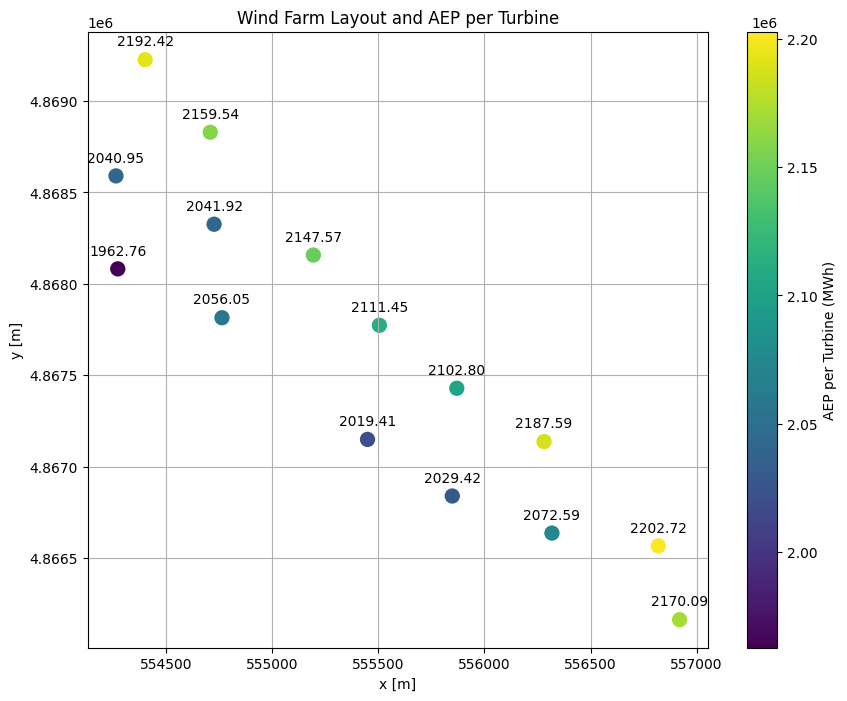

In [20]:
aep_per_turbine = simulation_result.aep().sum(dim=['wd', 'ws'])

import matplotlib.pyplot as plt

# Plotting the turbine locations
plt.figure(figsize=(10, 8))
plt.scatter(x, y, c=aep_per_turbine*1000, cmap='viridis', s=100)  # Color code by AEP
plt.colorbar(label='AEP per Turbine (MWh)')  # Add a color bar
plt.grid(True)
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('Wind Farm Layout and AEP per Turbine')

# Optionally, annotate each turbine with its AEP
for i, txt in enumerate(aep_per_turbine):
    plt.annotate(f'{txt:.2f}', (x[i], y[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.show()

<Figure size 640x480 with 0 Axes>

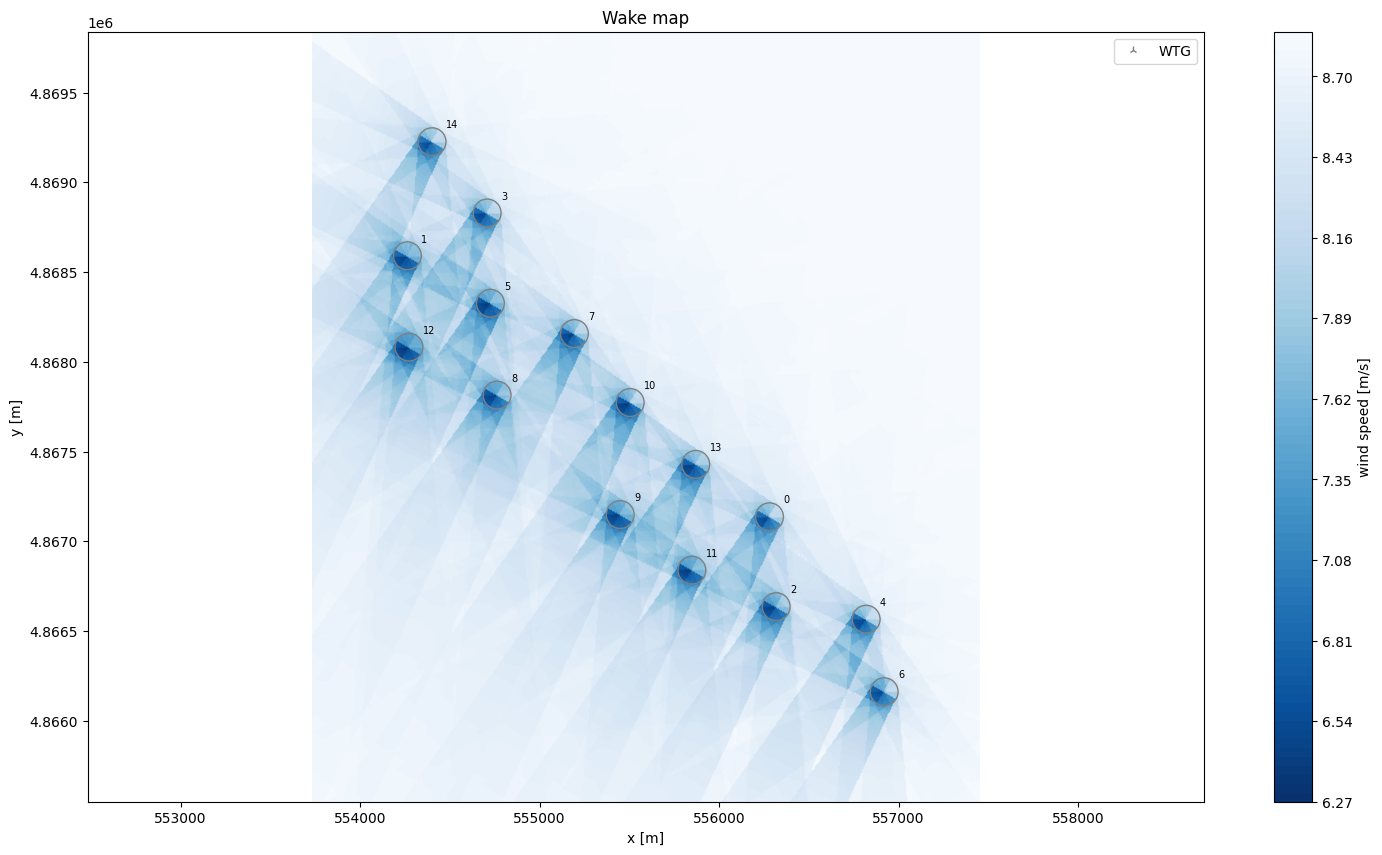

In [21]:
plt.figure()
flow_map = simulation_result.flow_map(ws=ds.ws, wd=ds.wd)
plt.figure(figsize=(18,10))
flow_map.plot_wake_map()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('Wake map');

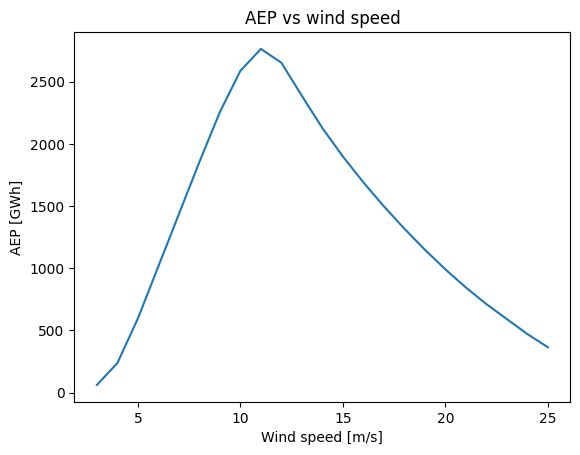

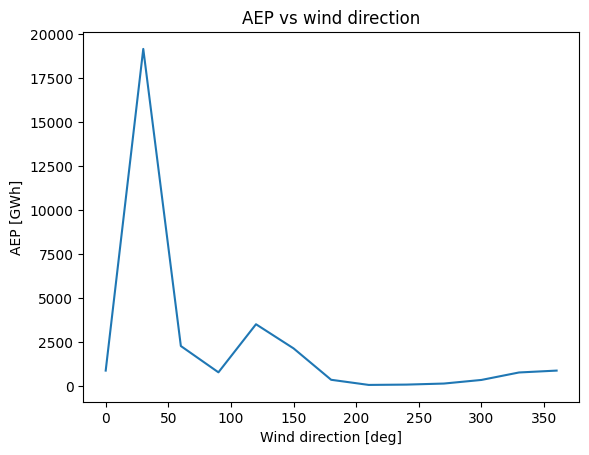

In [26]:
aep = simulation_result.aep()
plt.figure()
aep.sum(['wt','wd']).plot()
plt.xlabel("Wind speed [m/s]")
plt.ylabel("AEP [GWh]")
plt.title('AEP vs wind speed')

plt.figure()
aep.sum(['wt','ws']).plot()
plt.xlabel("Wind direction [deg]")
plt.ylabel("AEP [GWh]")
plt.title('AEP vs wind direction');